# Class : Systems Biology

---
## Before Class
1. Review slides on boolean and differential equation models.


---
## Learning Objectives

1. Run and plot simulation on oscillatory behavior from simple boolean system.  
* Run and plot simulation on oscillatory behavior from differential equation models.

---
## Background

Today we will be implementing two models for oscillatory behavior: simple boolean system and differential equation models, which have been successfully applied in the context of cell-cycle regulation modeling. 

Reference: [Ferrell JE et al., Cell, vol 144, 2011](https://www.sciencedirect.com/science/article/pii/S0092867411002431?via%3Dihub)

---
## Simple Boolean System Simulation
As an example in slide,

<img src="figures/Boolean_Model.png" width="150">

There are three nodes in this boolean model: `A, B and C`, and each node has a rule when being updated in each time step: `A: not B, B: not C, C: A`.

Start with the initial states `A: 1, B: 1, C: 1`, we will get the simulation results as below:

<img src="figures/Simulation.png" width="400">

In [70]:
class Boolean_Model:
    ''' Class for boolean models
    
    Class for holding boolean model parameters and to do simulation
    
    Private Attributes:
        _intial (dict): The initial states for nodes
        _rules (dict): The regulatory rules of boolean model 
    '''
    
    def __init__(self, initial, rules):
        self._initial = initial
        self._rules = rules
    
    @property
    def nodes(self):
        return self._initial.keys()
        
    def simulation(self,step=10):
        '''Funtion for simulation on boolean model
        
        Args:
            step (int): Number of steps for simulation
            
        Returns:
            results (int, list of dict): A dictionary of nodes containing their state in each simulation step
        
        Examples:
            #Create the boolean model
            >>> initial = {'A': 1, 'B': 1, 'C': 1}
            >>> rules = {'A': 'not B', 'B': 'not C', 'C': 'A'}
            
            >>> boolean_model = Boolean_Model(initial, rules)
            >>> boolean_model.simulation() #doctest: +NORMALIZE_WHITESPACE
            {'A': [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
             'B': [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
             'C': [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]}
            
        '''
        
        results = {}
        for node in self.nodes:
            results[node] = [self._initial[node]]
        locals().update(self._initial) #other ways to assign var from dict keys?

        node_update = {}
        for i in range(1,step+1):
            for node in self._rules:
                node_update[node] = int(eval(self._rules[node]))
                results[node].append(node_update[node])
            locals().update(node_update)
        
        return results

In [71]:
#Build the boolean model with initial states and the regulatory rules for each node
initial = {'A': 1, 'B': 1, 'C': 1}
rules = {'A': 'not B', 'B': 'not C', 'C': 'A'}

boolean_model = Boolean_Model(initial, rules)

In [72]:
#Perform simulation on the boolean model
results = boolean_model.simulation()
results

{'A': [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 'B': [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
 'C': [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]}

In [73]:
#Reference for ploting heatmap with matplotlib:
#https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
import matplotlib.pyplot as plt
def plot_simulation(results):
    '''Plot the simulation results as a heatmap:
    
    Args: 
        results (int, list of dict): A dictionary of nodes containing their state in each simulation step
    '''

    node = results.keys()
    states = np.array([k for k in results.values()])
    fig, ax = plt.subplots()
    im = ax.imshow(states)

    ax.set_xticks(np.arange(states.shape[1]))
    ax.set_yticks(np.arange(states.shape[0]))

    plt.xlabel('Steps')


    ax.set_yticklabels(node)

    for i in range(states.shape[0]):
        for j in range(states.shape[1]):
            text = ax.text(j,i,states[i,j],ha="center",va="center",color="w")
    plt.show()
    #plt.savefig('Simulation.png',dpi=150)

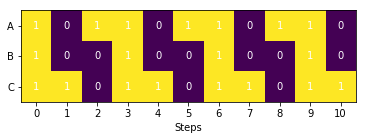

In [74]:
plot_simulation(results)

In [75]:
#Or just doing a line ploting...

In [76]:
import matplotlib.pyplot as plt
def plot_simulation(results):
    '''Plot the simulation results

    Args: 
        results (int, list of dict): A dictionary of nodes containing their state in each simulation step

    '''
    
    for node in results.keys():
        plt.plot(results[node],label=node)
        
    plt.xlabel('Steps')
    plt.ylabel('State')
    plt.yticks([0,1])
    plt.legend()
    plt.show()


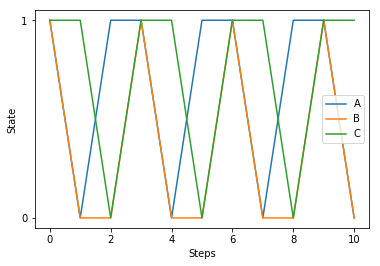

In [77]:
plot_simulation(results)

### Differential Equation Models Simulation

Instead of modeling discrete activity states and time steps with boolean system (which could be oversimplified), we could apply differential equations (or more specifically ordinary differential equations in our case) to model the rate of the change of activation in continuous time.

In [78]:
#You will need these imports
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

An example of simulating and ploting an one-ODE model from
[Ferrell JE et al., Cell, vol 144, 2011](https://www.sciencedirect.com/science/article/pii/S0092867411002431?via%3Dihub) (Fig. 3) is shown as below:

The negative feedback loop of CDK1 regulation is model by the following ODE:

<img src="figures/One-ODE.png" width="400">

The constant variables were:
$\alpha_{1}=0.1, \beta_{1}=1, K_{1}=0.5, n_{1}=8$

In [79]:
#Define ODE:
def eq_ODE1(y, t, alpha, beta, K, n):
    """ Equation for integration of CDK1 ODE
    
    Args:
        y (int): last y-value
        t (int): time value
        alpha, beta, K, n (args): parameters for the model
        
    Returns:
        y_out (float): result of equation
        
    Example:
    >>> eq_ODE1(0, 0, .1, 1, .5, 8)
    0.1
    
    """
    y_out = alpha-beta*y*(y**n)/(K**n + y**n)
    return y_out

In [80]:
def integrate_and_plot_ODE(equation, y_init, t_out, alpha, beta, K, n, legend):
    """ This function performs integration of the ODE and plots it
    
    Note that we use the scipy odeint funtion to perform the integration
    
    Args:
        equation (func): The function name of the equation that we are integrating over
                        This is expected to be a list of the equations in the ODE
        y_init (list): The initial y values for the model
        t_out (np array): array of time points to integrate over
        alpha, beta, K, n: model parameters to pass to equation
        legend (tuple): Names of items to add to legend
    
    """
    # Integrate ODE:
    y_out = odeint(equation, y_init, t_out, args=(alpha, beta, K, n))
    
    # Plot the results
    plt.xlabel('Time')
    plt.ylabel('Activity')
    plt.plot(t_out,y_out)
    plt.legend(legend,loc="upper right")
    
    return y_out

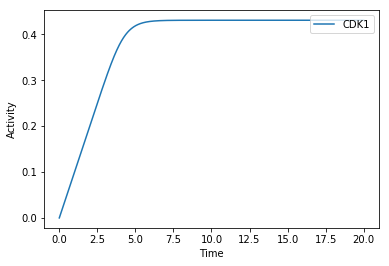

In [81]:
#Define constant variables in ODE:
alpha = 0.1
beta = 1
K = 0.5
n = 8

#Define initial point and interval for ploting
y = [0]
t_out = np.linspace(0,20,1000)

y_out = integrate_and_plot_ODE(eq_ODE1, y, t_out, alpha, beta, K, n, legend=('CDK1', '...'))

Now try simulating and ploting a three-ODE model from [Ferrell JE et al., Cell, vol 144, 2011](https://www.sciencedirect.com/science/article/pii/S0092867411002431?via%3Dihub) (Fig. 5):

<img src="figures/Three-ODE.png" width="400">


The constant variables were $\alpha_{1}=0.1,\alpha_{2}=3, \alpha_{3}=3, \beta_{1}=3, \beta_{2}=1, \beta_{3}=1, K_{1}=0.5, K_{2}=0.5, K_{3}=0.5, n_{1}=8, n_{2}=8, n_{3}=8$

In [82]:
#Three-ODE Model
def eq_ODE3(y, t, alpha, beta, K, n):
    """ Equation for integration of CDK1, APC, and PLK1 ODE
    
    Args:
        y (int): last y-value
        t (int): time value
        alpha, beta, K, n (args): parameters for the model
        
    Returns:
        y_out (float): result of equation
        
    Example:
    >>> eq_ODE3([0,0,0], [0,0,0], [0.1,3,3], [3,1,1], [0.5,0.5,0.5], [8,8,8])
    [0.1, 0.0, 0.0]
    
    """
    y_out = [] #[CDK1, PLK1, APC]
    y_out.append(alpha[0] - beta[0]*y[0]*(y[2]**n[0]/(K[0]**n[0] + y[2]**n[0])))
    y_out.append(alpha[1]*(1-y[1])*(y[0]**n[1]/(K[1]**n[1] + y[0]**n[1]))-beta[1]*y[1])
    y_out.append(alpha[2]*(1-y[2])*(y[1]**n[2]/(K[2]**n[2] + y[1]**n[2]))-beta[2]*y[2])
    
    return y_out

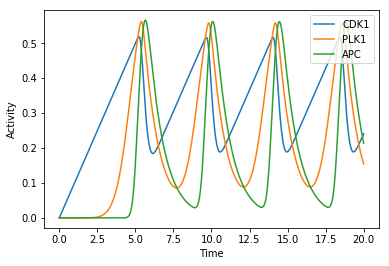

In [83]:
alpha = [0.1,3,3]
beta = [3,1,1]
K = [0.5,0.5,0.5]
n = [8,8,8]

y_init = [0,0,0]
tout = np.linspace(0,25,10000)

y_out = integrate_and_plot_ODE(eq_ODE3, y_init, t_out, alpha, beta, K, n, legend=('CDK1', 'PLK1', 'APC'))

Now try simulating and ploting a two-ODE model from [Ferrell JE et al., Cell, vol 144, 2011](https://www.sciencedirect.com/science/article/pii/S0092867411002431?via%3Dihub) (Fig. 4):

<img src="figures/Two-ODE.png">


The constant variables were: $\alpha_{1}=0.1, \alpha_{2}=3, \beta_{1}=3, \beta_{2}=1, K_{1}=0.5, K_{2}=0.5, n_{1}=8, n_{2}=8$

In [84]:
def eq_ODE2(y, t, alpha, beta, K, n):
    """ Equation for integration of CDK1 + APC ODE
    
    Args:
        y (int): last y-value
        t (int): time value
        alpha, beta, K, n (args): parameters for the model
        
    Returns:
        y_out (float): result of equation
        
    Example:
    >>> eq_ODE2([0,0], [0,0], [0.1,3], [3,1], [0.5,0.5], [8,8])
    [0.1, 0.0]
    
    """
    y_out = [] #[CDK1, APC]
    y_out.append(alpha[0]-beta[0]*y[0]*(y[1]**n[0]/(K[0]**n[0]+y[1]**n[0])))
    y_out.append(alpha[1]*(1-y[1])*(y[0]**n[1]/(K[1]**n[1]+y[0]**n[1]))-beta[1]*y[1])
    
    return y_out

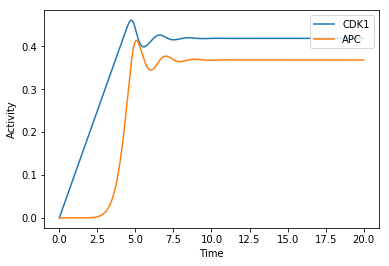

In [85]:
#Two-ODE model
alpha = [0.1,3]
beta = [3,1]
K = [0.5,0.5]
n = [8,8]

y_init = [0,0]
tout = np.linspace(0,25,1000)

y_out = integrate_and_plot_ODE(eq_ODE2, y_init, t_out, alpha, beta, K, n, legend=('CDK1', 'APC'))

In [86]:
import doctest
doctest.testmod()

TestResults(failed=0, attempted=7)